In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
from catboost import CatBoostClassifier, Pool, cv

In [19]:
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [20]:
# spaceship = pd.read_csv('spaceship-titanic/train.csv')
spaceship = pd.read_csv('data/train.csv')
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [21]:
# separate cabins for 3 columns


In [22]:
# maybe don't drop Cabin, it could be useful
spaceship.drop(['Name', 'Cabin'],axis=1,inplace=True)

In [23]:
spaceship.fillna({
    "CryoSleep": 0, "Age": 0, "VIP": 0, "RoomService": 0, 
    "FoodCourt": 0, "ShoppingMall": 0, "Spa": 0, "VRDeck": 0, 
    "Destination": "Unknown Destination", "HomePlanet": "Unknown HomePlanet",
}, inplace=True)

In [24]:
# check for missing values
spaceship.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [25]:
spaceship.Destination.value_counts()

TRAPPIST-1e            5915
55 Cancri e            1800
PSO J318.5-22           796
Unknown Destination     182
Name: Destination, dtype: int64

In [26]:
spaceship.HomePlanet.value_counts()

Earth                 4602
Europa                2131
Mars                  1759
Unknown HomePlanet     201
Name: HomePlanet, dtype: int64

In [27]:
spaceship_categorial = pd.get_dummies(spaceship[['Destination', 'HomePlanet']])
spaceship_categorial.head()

,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_Unknown Destination,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown HomePlanet
0,0,0,1,0,0,1,0,0
1,0,0,1,0,1,0,0,0
2,0,0,1,0,0,1,0,0
3,0,0,1,0,0,1,0,0
4,0,0,1,0,1,0,0,0


In [28]:
spaceship.drop(['Destination', 'HomePlanet'],axis=1,inplace=True)
spaceship = pd.concat([spaceship, spaceship_categorial], axis=1)

In [29]:
spaceship.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_Unknown Destination,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown HomePlanet
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,0,1,0,0,1,0,0
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,0,1,0,1,0,0,0
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,0,1,0,0,1,0,0
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0,0,1,0,0,1,0,0
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0,0,1,0,1,0,0,0


In [30]:
spaceship.shape

(8693, 18)

TypeError: Image data of dtype object cannot be converted to float

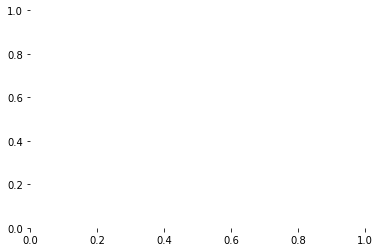

In [31]:
sns.heatmap(spaceship)

In [ ]:
# separate data to features and labels
X_train = spaceship.drop(['PassengerId', 'Transported'],axis=1)
y_train = spaceship['Transported']

In [ ]:
# normalize the data
transformer = Normalizer().fit(X_train)
X_train = transformer.transform(X_train)

In [ ]:
# train the model using gridsearchcv
# rfc = RandomForestClassifier()

# search_best = GridSearchCV(rfc, {
#     'n_estimators': range(5, 30, 5),
#     'max_depth': range(5, 30, 5),
#     'min_samples_split': range(50, 200, 50),
#     'min_samples_leaf': [1, 2, 5, 10],
# }, cv=5, return_train_score=False)
# search_best.fit(X_train, y_train)
# search_best.best_params_

In [ ]:
X_train.shape

(8693, 16)

In [ ]:
random_forest = RandomForestClassifier(
    n_estimators=20, max_depth=20, min_samples_split=100, min_samples_leaf=2
)
random_forest.fit(X_train, y_train)
random_forest.score(X_train, y_train)

0.816864143563787

In [ ]:
# random forest classification report 
y_pred = random_forest.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.79      0.81      4315
        True       0.80      0.85      0.82      4378

    accuracy                           0.82      8693
   macro avg       0.82      0.82      0.82      8693
weighted avg       0.82      0.82      0.82      8693



In [ ]:
# spaceship_test = pd.read_csv('spaceship-titanic/test.csv')
spaceship_test = pd.read_csv('data/test.csv')
spaceship_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [ ]:
spaceship_test.drop(['Name', 'Cabin'],axis=1,inplace=True)

In [ ]:
spaceship_test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64

In [ ]:
spaceship_test.fillna({
    "CryoSleep": 0, "Age": 0, "VIP": 0, "RoomService": 0, 
    "FoodCourt": 0, "ShoppingMall": 0, "Spa": 0, "VRDeck": 0, 
    "Destination": "Unknown Destination", "HomePlanet": "Unknown HomePlanet",
}, inplace=True)

In [ ]:
spaceship_test_categorical = pd.get_dummies(spaceship_test[['Destination', 'HomePlanet']])
spaceship_test = pd.concat([spaceship_test, spaceship_test_categorical], axis=1)
spaceship_test.drop(['Destination', 'HomePlanet'],axis=1,inplace=True)
spaceship_test.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_Unknown Destination,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown HomePlanet
0,0013_01,True,27.0,False,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0,0,0
1,0018_01,False,19.0,False,0.0,9.0,0.0,2823.0,0.0,0,0,1,0,1,0,0,0
2,0019_01,True,31.0,False,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0
3,0021_01,False,38.0,False,0.0,6652.0,0.0,181.0,585.0,0,0,1,0,0,1,0,0
4,0023_01,False,20.0,False,10.0,0.0,635.0,0.0,0.0,0,0,1,0,1,0,0,0


In [ ]:
# create submission based on catboost classifier
X_test = spaceship_test.drop(['PassengerId'],axis=1)
X_test = transformer.transform(X_test)

# catboost prediction
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=10)
catboost_model.fit(X_train, y_train, verbose=False)
catboost_y_pred = catboost_model.predict(X_test)

In [ ]:
# get feauture importance
feature_importance = pd.DataFrame(list(zip(spaceship_test.columns, catboost_model.feature_importances_)), columns=['feature', 'importance'])
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance

,feature,importance
1,CryoSleep,15.590312
6,ShoppingMall,11.164271
4,RoomService,10.628812
7,Spa,10.346544
12,Destination_Unknown Destination,10.062484
3,VIP,9.761717
5,FoodCourt,8.947552
10,Destination_PSO J318.5-22,8.073964
13,HomePlanet_Earth,4.951361
0,PassengerId,2.840051


In [ ]:
catboost_model.eval_metrics(Pool(X_train, y_train), ['AUC'], plot=True)

In [ ]:
#put prediction to submission file
submission = pd.DataFrame({
        "PassengerId": spaceship_test["PassengerId"],
        "Transported": catboost_y_pred
    })
submission.to_csv('catboost_submission.csv', index=False)

In [ ]:
rfc_submission = pd.DataFrame({
    "PassengerId": spaceship_test["PassengerId"],
    "Transported": random_forest.predict(spaceship_test.drop('PassengerId', axis=1))
})

C:\Users\dimaz\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
rfc_submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [ ]:
rfc_submission.Transported.value_counts()

True     2913
False    1364
Name: Transported, dtype: int64

In [ ]:
submission.Transported.value_counts()

True     2260
False    2017
Name: Transported, dtype: int64